# Green’s function estimation from ambient noise signals with limited illumination in 3D

In [2]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.integrate import nquad
sns.set_style("darkgrid")
import scipy.linalg

In [ ]:
N = 10_000
mean = np.array([0, -200, 0])
sigma = np.diag([100, 50, 100])
cov = sigma**2
y = np.random.multivariate_normal(mean, cov, N)

X_1 = np.array([[0, 50*(j-1), 0] for j in range(1, 6)])
X_2 = np.array([[0, 5*(j-1), 0] for j in range(1, 6)])
X_3 = np.array([[50*(j-3), 100, 0] for j in range(1, 6)])

X_list = [X_1, X_2, X_3]
Tau = [np.linspace(-225, -25, 1000), np.linspace(-30, 0, 200), np.linspace(-25, 25, 200)]

In [16]:
c0, tau = 1, 0

def g_sec(t):
    t_squared = t**2
    return np.exp(-t_squared/4)*(t_squared-2)/(8*np.sqrt(np.pi))

## 1. 

### $C_N$ : Calculous

Let $\tau \in \mathbb{R}$ be the time lag between two signals. 

$$\displaystyle 
\begin{aligned}
C_N(\tau,\mathbf{x}_j,\mathbf{x}_1) &= \frac{1}{2\pi N} \sum_{s=1}^{N} \int_{-\infty}^{\infty}  \hat{F}(\omega)\overline{\hat{G}(\omega,\mathbf{x}_j,\mathbf{y}_s)}\hat{G}(\omega,\mathbf{x}_1,\mathbf{y}_s)e^{-i\omega\tau} \mathrm{d}\omega \\
&=\frac{1}{16\pi^2N}\sum_{s=1}^{N} \frac{1}{|\mathbf{x}_j-\mathbf{y}_s||\mathbf{x}_1-\mathbf{y}_s|}\frac{1}{2\pi}\int_{-\infty}^{\infty} \omega^2e^{-\omega^2}\exp{\left(-i\omega\left(\frac{|\mathbf{x}_j-\mathbf{y}_s|-|\mathbf{x}_1-\mathbf{y}_s|}{c_0}+\tau\right)\right)} \mathrm{d}\omega
\end{aligned}
$$

Let's define $g : \left\{\begin{aligned} \mathbb{R} &\to \mathbb{R} \\ t &\mapsto \frac{1}{\sqrt{4\pi}}e^{-t^2/4} \end{aligned}\right.$. 

It is a standard result that the Fourier transform of $g$ is $\hat{g} : \left\{\begin{aligned} \mathbb{R} &\to \mathbb{R} \\ \omega &\mapsto e^{-\omega^2} \end{aligned}\right.$.

Then, $\widehat{g''}(\omega) = - \omega^2 \hat{g}(\omega) = - \widehat{F}(\omega)$ for all $\omega \in \mathbb{R}$.

So, 
$$\displaystyle 
\boxed{\begin{aligned} 
C_N(\tau,\mathbf{x}_j,\mathbf{x}_1) 
&= -\frac{1}{16\pi^2N}\sum_{s=1}^{N} \frac{1}{|\mathbf{x}_j-\mathbf{y}_s||\mathbf{x}_1-\mathbf{y}_s|}g''\left(\frac{|\mathbf{x}_j-\mathbf{y}_s|-|\mathbf{x}_1-\mathbf{y}_s|}{c_0}+\tau\right)\end{aligned}}$$

### $C_N$ : Computation

In [17]:
def C_N(tau, x_1, x_2, y, c0=1):
    x_2_minus_y = np.linalg.norm(x_2-y, axis=1)
    x_1_minus_y = np.linalg.norm(x_1-y, axis=1)
    g_sec_term = g_sec((x_1_minus_y - x_2_minus_y) / c0 + tau) / (x_2_minus_y * x_1_minus_y)
    return -np.mean(g_sec_term)/(16*np.pi**2)

### $C_N$ : Plots and results

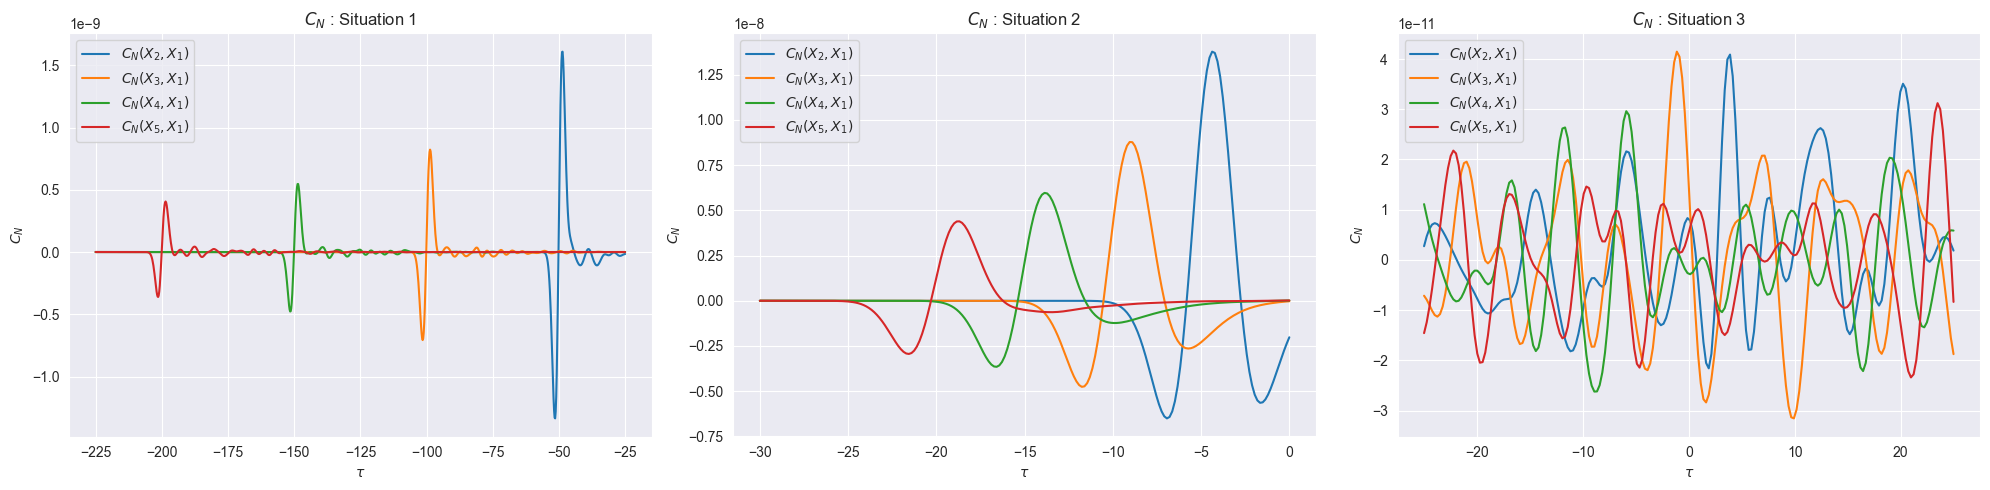

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

titles = ["$C_N$ : Situation 1", "$C_N$ : Situation 2", "$C_N$ : Situation 3"]

for i, X in enumerate(X_list):
    C_N_values = [np.array([C_N(tau, X[j], X[0], y) for tau in Tau[i]]) for j in range(1, 5)]
    for j, C_N_val in enumerate(C_N_values):
        axs[i].plot(Tau[i], C_N_val, label=f"$C_N(X_{{{j+2}}},X_1)$")
    axs[i].legend()
    axs[i].set_xlabel("$\\tau$")
    axs[i].set_ylabel("$C_N$")
    axs[i].set_title(titles[i])

plt.tight_layout()
plt.show()

Here, we suppose that the celerity of the waves is $c_0 = 1$. On average, the source points are at location $\mathbf{\mu} = (0,-200,0)$ which is on the $y$-axis.

- In experiment 1 and 2 : The receivers are all aligned according the the $y$-axis (a symmetry axis of the noise emitted), and with $\mathbf{\mu}$. Therefore, it is expected that the received signals for 2 receivers $\mathbf{x}_i$ and $\mathbf{x}_j$ will be the same (only the amplitude will change) but with a delay $\tau = \frac{|\mathbf{x}_i-\mathbf{\mu}|-|\mathbf{x}_j-\mathbf{\mu}|}{c_0}$ (time for the signal to travel from $\mathbf{x}_i$ to $\mathbf{x}_j$).

- In experiment 3 : The receivers are not aligned with $\mathbf{\mu}$, meaning the received signals will differ in both shape and amplitude. As a result, we do not expect to observe any significant correlation between the signals recorded by different receivers. We only observe a residual correlation due to noise.

## 2.

### $C_{T,N}$ : Calculous

Let us fix $t\in\mathbb{R},\mathbf{x}\in\mathbb{R}^3$.

$$\begin{aligned}
u(t,\mathbf{x}) 
&= \int_{\mathbb{R}^3}\int_{\mathbb{R}} G(t-t',\mathbf{x},\mathbf{y})n(t',\mathbf{y})\mathrm{d}t'~\mathrm{d}\mathbf{y} \\
&= \int_{\mathbb{R}^3}\int_{\mathbb{R}} G(t-t',\mathbf{x},\mathbf{y})\frac
{1}{\sqrt{N}}\sum_{s=1}^Nn_s(t')\delta(\mathbf{y}-\mathbf{y}_s)\mathrm{d}t'~\mathrm{d}\mathbf{y} \\
&=\frac{1}{\sqrt{N}}\sum_{s=1}^N\int_{\mathbb{R}}G(t-t',\mathbf{x},\mathbf{y}_s)n_s(t')\mathrm{d}t' \\
&=\frac{1}{\sqrt{N}}\sum_{s=1}^N\int_{\mathbb{R}}\frac{1}{4\pi|\mathbf{x}-\mathbf{y}_s|}\delta\left(t-\frac{|\mathbf{x}-\mathbf{y}_s|}{c_0}-t'\right)n_s(t')\mathrm{d}t' \\
&=\frac{1}{4\pi\sqrt{N}}\sum_{s=1}^N\frac{1}{|\mathbf{x}-\mathbf{y}_s|}n_s\left(t-\frac{|\mathbf{x}-\mathbf{y}_s|}{c_0}\right) \\
\end{aligned}
$$

Therefore, for $\tau\in\mathbb{R}$,

$$
\boxed{u(t,\mathbf{x}_1)u(t+\tau,\mathbf{x}_2) = \frac{1}{16\pi^2N}\sum_{s=1}^N\sum_{s'=1}^N\frac{1}{|\mathbf{x}_1-\mathbf{y}_s||\mathbf{x}_2-\mathbf{y}_{s'}|}n_s\left(t-\frac{|\mathbf{x}_1-\mathbf{y}_s|}{c_0}\right)n_{s'}\left(t+\tau-\frac{|\mathbf{x}_2-\mathbf{y}_{s'}|}{c_0}\right)}
$$

Moreover, we can verify that we have indeed $\mathbb{E}\left[C_{T,N}(\tau,\mathbf{x}_1,\mathbf{x}_2)\right] = C_N(\tau,\mathbf{x}_1,\mathbf{x}_2)$. 

For that, one only has to remark that $\mathbb{E}\left[n_s(t_1)n_{s'}(t_2)\right] = \left\{\begin{aligned} F(t_1-t_2) \quad&\text{ if }s=s' \\ 0 \quad&\text{ otherwise} \end{aligned}\right.$

Then, we have 
$$\begin{aligned}
\mathbb{E}\left[C_{T,N}(\tau,\mathbf{x}_1,\mathbf{x}_2)\right] 
&= \frac{1}{T-|\tau|}\int_0^{T-|\tau|}\mathbb{E}\left[u(t,\mathbf{x}_1)u(t+\tau,\mathbf{x}_2)\right]\mathrm{d}t \\
&= \frac{1}{T-|\tau|}\int_0^{T-|\tau|}\frac{1}{16\pi^2N}\sum_{s=1}^N\frac{1}{|\mathbf{x}_1-\mathbf{y}_s||\mathbf{x}_2-\mathbf{y}_{s}|}F\left(t-\frac{|\mathbf{x}_1-\mathbf{y}_s|}{c_0}-t-\tau+\frac{|\mathbf{x}_2-\mathbf{y}_{s}|}{c_0}\right)\mathrm{d}t \\
&= \frac{1}{16\pi^2N}\sum_{s=1}^N\frac{1}{|\mathbf{x}_1-\mathbf{y}_s||\mathbf{x}_2-\mathbf{y}_{s}|}F\left(\frac{|\mathbf{x}_1-\mathbf{y}_s| - |\mathbf{x}_2-\mathbf{y}_{s}|}{c_0}-\tau\right)\frac{1}{T-|\tau|}\int_0^{T-|\tau|}\mathrm{d}t \\
&= C_N(\tau,\mathbf{x}_1,\mathbf{x}_2) &\text{ ($F$ is even and $F=-g$)}
\end{aligned}
$$

### $C_{T,N}$ : Computation 

In [19]:
def F(t):
    return -np.exp(-t**2 / 4) * (t**2 - 2) / (8 * np.sqrt(np.pi))  # = -g_sec(t)

def generate_gaussian_processes(N, t, F):
    """Efficiently generate Gaussian processes using vectorized operations"""
    Nt = len(t)
    
    # Create pairwise difference matrix
    t_diff = t[:, None] - t[None, :]
    C = F(t_diff)  # Apply function element-wise

    # Cholesky decomposition
    L = scipy.linalg.cholesky(C + 1e-6 * np.eye(Nt), lower=True)
    
    # Generate random samples and apply Cholesky factor
    Z = np.random.randn(Nt, N)
    gp_realizations = L @ Z 

    return gp_realizations.T  # Shape (N, Nt)

In [20]:
def C_T_N(tau, x_1, x_2, y, c0=1, T=10, dt=0.1):
    """Optimized computation of C_T_N"""
    x_1 = np.asarray(x_1)
    x_2 = np.asarray(x_2)
    y = np.asarray(y)
    
    # Compute distances efficiently
    x_1_minus_y = np.linalg.norm(x_1 - y, axis=1)
    x_2_minus_y = np.linalg.norm(x_2 - y, axis=1)

    t_max = T - min(np.min(x_1_minus_y) / c0, np.min(x_2_minus_y) / c0) + max(0, tau)
    t_min = -max(np.max(x_1_minus_y) / c0, np.max(x_2_minus_y) / c0) + min(0, tau)

    t_k = np.arange(0, T, dt)  # Discrete time steps
    t_interp = np.arange(t_min, t_max, dt)  # Interpolation grid

    Nt = len(t_k)

    # Generate Gaussian process realizations
    n_s_tk = generate_gaussian_processes(len(x_1_minus_y), t_interp, F)  # Shape (N, T)

    # Precompute factor matrix
    factor_matrix = 1 / np.outer(x_1_minus_y, x_2_minus_y)

    # Vectorized interpolation
    delayed_n_s = np.array([np.interp(t_k - x_1_minus_y[i] / c0, t_interp, n_s_tk[i]) for i in range(len(x_1_minus_y))])
    delayed_n_s_p = np.array([np.interp(t_k + tau - x_2_minus_y[i] / c0, t_interp, n_s_tk[i]) for i in range(len(x_2_minus_y))])

    # Compute correlation using vectorized dot product
    Corr_t_k = np.einsum('ij,ik,jk->k', factor_matrix, delayed_n_s, delayed_n_s_p)
    return np.sum(Corr_t_k) / (16 * len(x_1_minus_y) * np.pi**2 * Nt)

### Compare $C_{T,N}$ and $C_N$

For the first 2 situations, we take 2 receivers $\mathbf{x_j}$ and $\mathbf{x_1}$ and we take  $\displaystyle\tau_j\approx\argmax_{\tau} C_N(\tau,\mathbf{x_j},\mathbf{x_1})$.

For the 3rd situation, there is no clean maximum so we just take the arbitrary value $\tau_j = 12$.

We will study $(C_{T,N}(\tau_j,\mathbf{x}_j,\mathbf{x}_1))_{T\in\mathcal{T}}$ and compare it to $C_N(\tau_j,\mathbf{x}_j,\mathbf{x}_1)$.

Here, we took : $\mathcal{T} \coloneqq \{0.5, 1, 5, 10, 20, 50, 100\}$ and $N=10 000$.

#### Situation 1

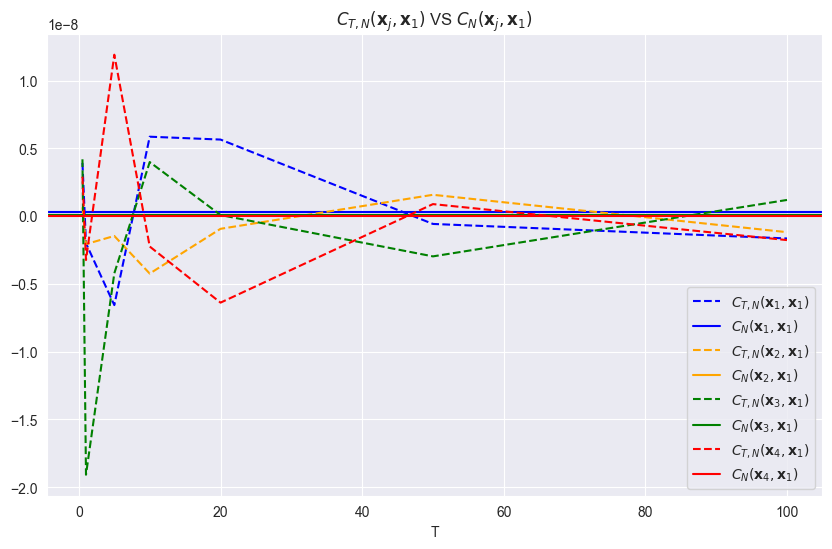

In [21]:
# X_1[1] and X_1[0] with tau = -50
T_values = [0.5, 1, 5, 10, 20, 50, 100]
taus = [-50,-100,-150,-200]
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(10, 6))

for j in range(1, 5):
    c_n = C_N(taus[j-1], X_1[j], X_1[0], y)  # Ensure `C_N` is defined
    C_T_N_results = [C_T_N(taus[j-1], X_1[j], X_1[0], y, T=T, dt=0.1) for T in T_values]
    plt.plot(T_values, C_T_N_results, color=colors[j-1], linestyle='--', label=f'$C_{{T,N}}(\mathbf{{x}}_{{{j}}},\mathbf{{x}}_{{1}})$')
    plt.axhline(y=c_n, color=colors[j-1], label=f'$C_N(\mathbf{{x}}_{{{j}}},\mathbf{{x}}_{{1}})$')
plt.legend()
plt.xlabel('T')
plt.title(f'$C_{{T,N}}(\mathbf{{x}}_{{j}},\mathbf{{x}}_{{1}})$ VS $C_N(\mathbf{{x}}_{{j}},\mathbf{{x}}_{{1}})$')
plt.show()

We can observe that $C_{T,N}(\tau_j,\mathbf{x}_j,\mathbf{x}_1)\rightarrow C_{N}(\tau_j,\mathbf{x}_j,\mathbf{x}_1)$  when $T$ goes to infinity.

#### Situation 2

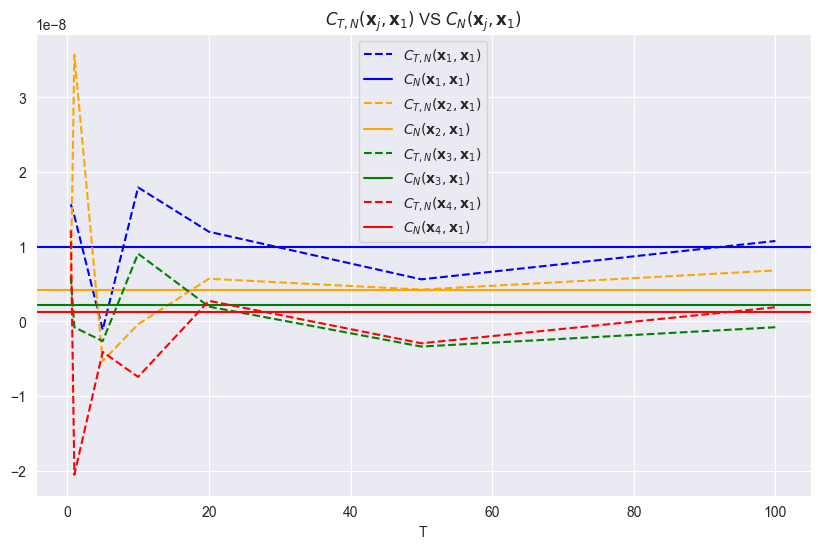

In [22]:
# X_1[1] and X_1[0] with tau = -50
T_values = [0.5, 1, 5, 10, 20, 50, 100]
taus = [-5,-10,-15,-20]
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(10, 6))

for j in range(1, 5):
    c_n = C_N(taus[j-1], X_2[j], X_2[0], y)  # Ensure `C_N` is defined
    C_T_N_results = [C_T_N(taus[j-1], X_2[j], X_2[0], y, T=T, dt=0.1) for T in T_values]
    plt.plot(T_values, C_T_N_results, color=colors[j-1], linestyle='--', label=f'$C_{{T,N}}(\mathbf{{x}}_{{{j}}},\mathbf{{x}}_{{1}})$')
    plt.axhline(y=c_n, color=colors[j-1], label=f'$C_N(\mathbf{{x}}_{{{j}}},\mathbf{{x}}_{{1}})$')
plt.legend()
plt.xlabel('T')
plt.title(f'$C_{{T,N}}(\mathbf{{x}}_{{j}},\mathbf{{x}}_{{1}})$ VS $C_N(\mathbf{{x}}_{{j}},\mathbf{{x}}_{{1}})$')
plt.show()

We can observe that $C_{T,N}(\tau_j,\mathbf{x}_j,\mathbf{x}_1)\rightarrow C_{N}(\tau_j,\mathbf{x}_j,\mathbf{x}_1)$  when $T$ goes to infinity.

#### Situation 3

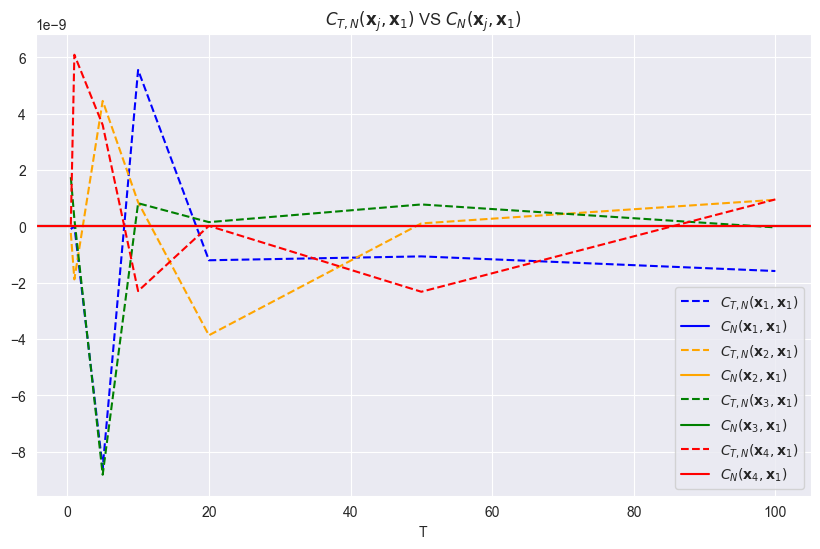

In [23]:
# X_1[1] and X_1[0] with tau = -50
T_values = [0.5, 1, 5, 10, 20, 50, 100]
taus = [12]*4
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(10, 6))

for j in range(1, 5):
    c_n = C_N(taus[j-1], X_3[j], X_3[0], y)  # Ensure `C_N` is defined
    C_T_N_results = [C_T_N(taus[j-1], X_3[j], X_3[0], y, T=T, dt=0.1) for T in T_values]
    plt.plot(T_values, C_T_N_results, color=colors[j-1], linestyle='--', label=f'$C_{{T,N}}(\mathbf{{x}}_{{{j}}},\mathbf{{x}}_{{1}})$')
    plt.axhline(y=c_n, color=colors[j-1], label=f'$C_N(\mathbf{{x}}_{{{j}}},\mathbf{{x}}_{{1}})$')
plt.legend()
plt.xlabel('T')
plt.title(f'$C_{{T,N}}(\mathbf{{x}}_{{j}},\mathbf{{x}}_{{1}})$ VS $C_N(\mathbf{{x}}_{{j}},\mathbf{{x}}_{{1}})$')
plt.show()

The convergence is less good here. The correlations are too small and noisy to be able to see a clear convergence. 

### $C^{(1)}$ : Calculous

$$\begin{aligned}
C^{(1)}(\tau,\mathbf{x}_1,\mathbf{x}_2) 
&= \frac{1}{2\pi}\int\mathrm{d}\omega\int\mathrm{d}\mathbf{y}K(\mathbf{y})\widehat{F}(\omega)\overline{\hat{G}(\omega,\mathbf{x}_1,\mathbf{y})}\hat{G}(\omega,\mathbf{x}_2,\mathbf{y})e^{-i\omega\tau} \\
&=-\frac{1}{16\pi^2}\int\mathrm{d}\mathbf{y}K(\mathbf{y})\frac{1}{|\mathbf{x}_1-\mathbf{y}||\mathbf{x}_2-\mathbf{y}|}g''\left(\frac{|\mathbf{x}_1-\mathbf{y}|-|\mathbf{x}_2-\mathbf{y}|}{c_0}+\tau\right)
\end{aligned}$$


### $C^{(1)}$ : Computation

We will approximate this integral by a quadrature formula.

In [ ]:
# Define the limits for integration (approximating infinity)
lower_limit = mean - 2 * np.diag(cov)
upper_limit = mean + 2 * np.diag(cov)
ranges = np.array((lower_limit, upper_limit)).T

In [ ]:
def integrand(y1, y2, y3, x_1, x_2, tau, c0, mu, sigma):
    y = np.array([y1, y2, y3])
    dist_x1_y = np.linalg.norm(x_1 - y)
    dist_x2_y = np.linalg.norm(x_2 - y)
    time_delay = (dist_x1_y - dist_x2_y) / c0 + tau    
    K = np.exp(-np.sum((y - mu)**2 / (2 * sigma**2))) / (np.prod(sigma) * (2 * np.pi)**(3/2))
    return - K * (1 / (16*np.pi**2 * dist_x1_y * dist_x2_y)) * g_sec(time_delay)

def C1(tau, x_1, x_2, c0=1, mean=mean, sigma=sigma):
    result, _ = nquad(integrand, ranges, args=(x_1, x_2, tau, c0, mean, np.diag(sigma)))
    return result

def compute_C1_for_Xj(Tau, X_j, X_0, desc):
    return np.array(Parallel(n_jobs=60)(
        delayed(C1)(tau, X_j, X_0) for tau in tqdm(Tau, desc=desc)
    ))

In [ ]:
X_list = [X_1, X_2, X_3]
Tau = [np.linspace(-225, -25, 1000), np.linspace(-30, 0, 200), np.linspace(-25, 25, 200)]

C1_values = []
for i, X in enumerate(X_list):
    C1_values.append([compute_C1_for_Xj(Tau[i], X[j], X[0], f"1 : (X_{j+1},X_1)") for j in range(1, 5)])

In [19]:
#save in files C1_values
np.save("C1_values_1.npy", np.array(C1_values[0]))
np.save("C1_values_2.npy", np.array(C1_values[1]))
np.save("C1_values_3.npy", np.array(C1_values[2]))

### $C^{(1)}$ : Plots

In [24]:
C1_values = [np.load("C1_values_1.npy"), np.load("C1_values_2.npy"), np.load("C1_values_3.npy")]

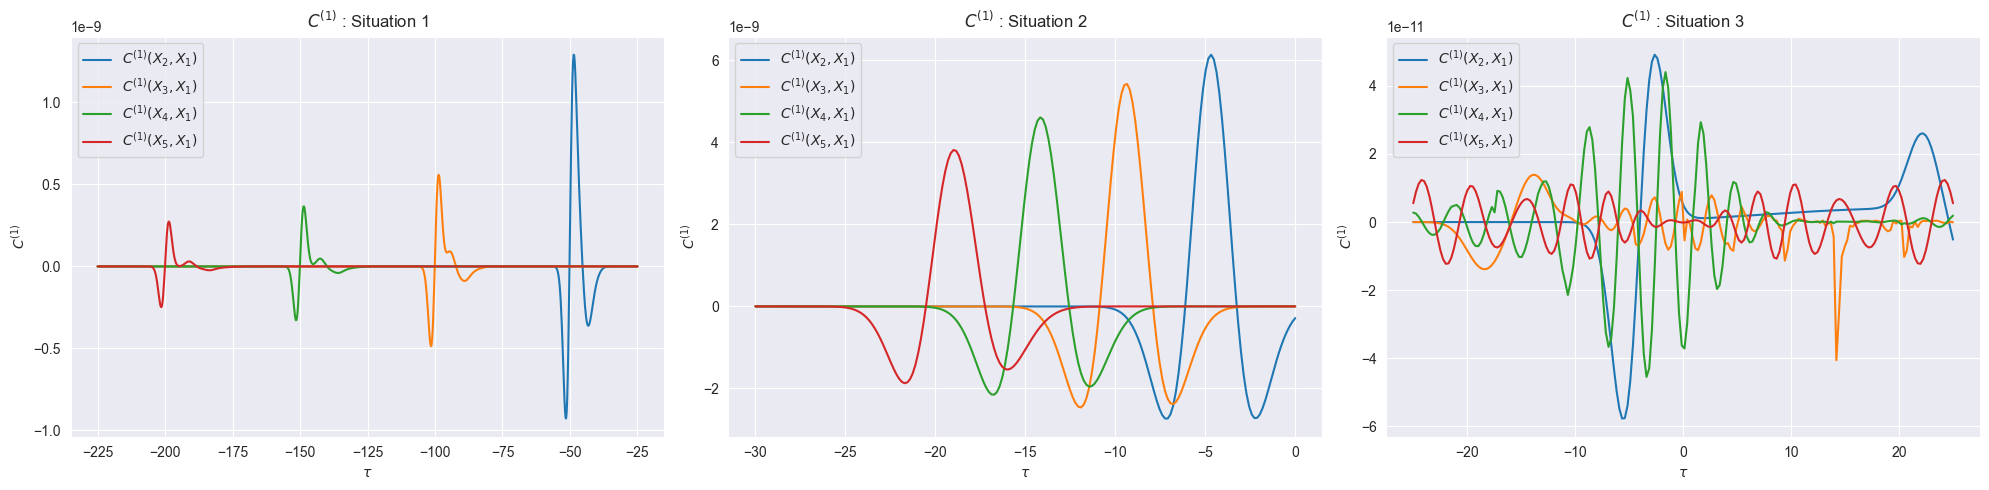

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
titles = ["$C^{(1)}$ : Situation 1", "$C^{(1)}$ : Situation 2", "$C^{(1)}$ : Situation 3"]

for i, C1_vals in enumerate(C1_values):
    for j, C1_val in enumerate(C1_vals):
        axs[i].plot(Tau[i], C1_val, label=f"$C^{{(1)}}(X_{{{j+2}}},X_1)$")
    axs[i].legend()
    axs[i].set_xlabel("$\\tau$")
    axs[i].set_ylabel("$C^{(1)}$")
    axs[i].set_title(titles[i])

plt.tight_layout()
plt.show()

### Compare $C_N$ and $C^{(1)}$.

In [59]:
N_values = [100, 1_000, 10_000, 100_000]

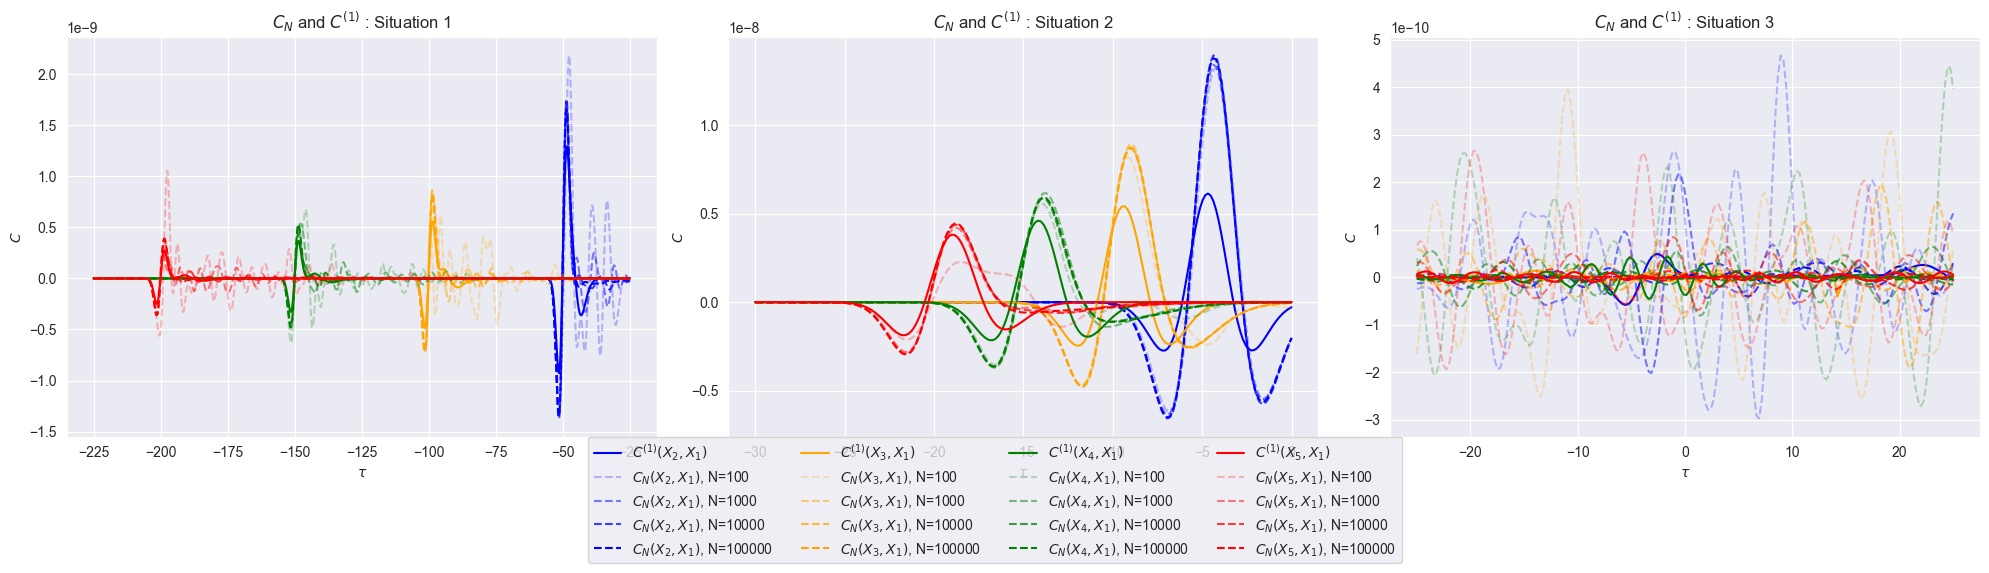

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
titles = ["$C_N$ and $C^{(1)}$ : Situation 1", "$C_N$ and $C^{(1)}$ : Situation 2", "$C_N$ and $C^{(1)}$ : Situation 3"]
colors = ['blue', 'orange', 'green', 'red']

# Store legend handles and labels
handles, labels = [], []

for i, X in enumerate(X_list):
    for j in range(1, 5):
        # Plot C^{(1)}
        line, = axs[i].plot(Tau[i], C1_values[i][j-1], color=colors[j-1], label=f"$C^{{(1)}}(X_{{{j+1}}},X_1)$")
        if i == 0:  # Collect legend info only once
            handles.append(line)
        
        # Plot C_N for each N in N_values
        for k, N in enumerate(N_values):
            y = np.random.multivariate_normal(mean, cov, N)
            C_N_values = np.array([C_N(tau, X[j], X[0], y) for tau in Tau[i]])
            line, = axs[i].plot(Tau[i], C_N_values, color=colors[j-1], linestyle='--', alpha=(k+1)/len(N_values), 
                                label=f"$C_N(X_{{{j+1}}},X_1)$, N={N}")
            if i == 0:  # Collect legend info only once
                handles.append(line)

    axs[i].set_xlabel("$\\tau$")
    axs[i].set_ylabel("$C$")
    axs[i].set_title(titles[i])

# Create one global legend outside the plot
fig.legend(handles, [h.get_label() for h in handles], loc="lower center",  ncol=4, fontsize=10, bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.show()


# 3.

Let's compute the variance of $C_{T,N}(\tau,x,x')$

Let's work in the frequency domain:

$$\mathbb{E}[u(t,x)u(t',x')]=\frac{1}{2\pi N}\displaystyle\sum_{s=1}^N\int d\omega \overline{\hat{G}(\omega,x,y_s)}\hat{G}(\omega,x',y_{s})\hat{F}(\omega)e^{i\omega(t-t')}$$

So, $$\mathbb{E}[C_{T,N}(\tau,x,x')^2]=\frac{1}{(T-|\tau|)^2}\int_0^{T-\tau}\int_0^{T-\tau}\mathbb{E}[u(t,x)u(t+\tau,x')u(t',x)u(t'+\tau,x')]dtdt'$$

When using Isserlis' Formula, we obtain

\begin{align*}
& \mathbb{E}[u(t,x)u(t+\tau,x')u(t',x)u(t'+\tau,x')]  \\
& =\frac{1}{(2\pi N)^2}\displaystyle\sum_{s,s'=1}^N\int\int dwdw'\overline{\hat{G}(\omega,x,y_s)}\hat{G}(\omega,x',y_s)\overline{\hat{G}(\omega',x,y_{s'})}\hat{G}(\omega',x',y_{s'})\hat{F}(\omega)\hat{F}(\omega')e^{-i\tau(\omega+\omega')}\\
& +\frac{1}{(2\pi N)^2}\displaystyle\sum_{s,s'=1}^N\int\int dwdw'|\hat{G}(\omega,x,y_s)|^2|\hat{G}(\omega',x',y_{s'})|^2\hat{F}(\omega)\hat{F}(\omega')e^{i(t-t')(\omega+\omega')} \\
& +\frac{1}{(2\pi N)^2}\displaystyle\sum_{s,s'=1}^N\int\int dwdw'\overline{\hat{G}(\omega,x,y_s)}\hat{G}(\omega,x',y_s)\overline{\hat{G}(\omega',x',y_{s'})}\hat{G}(\omega',x,y_{s'})\hat{F}(\omega)\hat{F}(\omega')e^{i(t-t')(\omega+\omega')-i\tau(\omega-\omega')}\\
\end{align*}

Using $ \mathbb{V}[C_{T,N}(\tau,x,x')] = \mathbb{E}[C_{T,N}(\tau,x,x')^2]-\mathbb{E}[C_{T,N}(\tau,x,x')]^2$, we obtain

\begin{align*}
    & \mathbb{V}[C_{T,N}(\tau,x,x')]\\
    & =\frac{1}{(T-|\tau|)^2(2\pi N)^2}\displaystyle\sum_{s,s'=1}^N\int\int dwdw'|\hat{G}(\omega,x,y_s)|^2|\hat{G}(\omega',x',y_{s'})|^2\hat{F}(\omega)\hat{F}(\omega')\int\int_{0}^{T-|\tau|}e^{i(t-t')(\omega+\omega')}dtdt' \\
& +\frac{1}{(T-|\tau|)^2(2\pi N)^2}\displaystyle\sum_{s,s'=1}^N\int\int dwdw'\overline{\hat{G}(\omega,x,y_s)}\hat{G}(\omega,x',y_s)\overline{\hat{G}(\omega',x',y_{s'})}\hat{G}(\omega',x,y_{s'})\hat{F}(\omega)\hat{F}(\omega')e^{-i\tau(\omega-\omega')}\int\int_{0}^{T-|\tau|}e^{i(t-t')(\omega+\omega')}dtdt'\\
\end{align*}


We will use the following calculation which has an easy proof:

$$\int_{0}^T\int_0^T e^{i(t-t')(\omega+\omega')}dtdt'=T^2\text{sinc}^2\left(\frac{\omega+\omega'}{2}T\right)$$

We will also use the following approximation for large $T$: $$T^2\text{sinc}^2\left(\frac{\omega+\omega'}{2}T\right)\approx 2\pi T\delta(\omega+\omega')$$

Thus, for large $T$, 

\begin{align*}
    & \mathbb{V}[C_{T,N}(\tau,x,x')]\\
    & \approx\frac{1}{2\pi TN^2}\int d\omega |\hat{F}(\omega)|^2\displaystyle\sum_{s=1}^N |\hat{G}(\omega,x,y_s)|^2\displaystyle\sum_{s=1}^N |\hat{G}(\omega,x',y_s)|^2\\
& +\frac{1}{2\pi TN^2}\int d\omega |\hat{F}(\omega)|^2 \left(\displaystyle\sum_{s=1}^N\hat{G}(\omega,x,y_s)\overline{\hat{G}(\omega,x',y_s)}\right)^2 e^{-2i\tau\omega}
\end{align*}



Then, by the law of large numbers, we can approximate for large $N$, 
$$\dfrac{1}{N}\displaystyle\sum_{s=1}^N  |\hat{G}(\omega,x,y_s)|^2\approx \int |\hat{G}(\omega,x,y)|^2K(y)dy$$ 
and 
$$ \dfrac{1}{N^2}\left(\displaystyle\sum_{s=1}^N\hat{G}(\omega,x,y_s)\overline{\hat{G}(\omega,x',y_s)}\right)^2\approx  \left(\int\hat{G}(\omega,x,y)\overline{\hat{G}(\omega,x',y)}K(y)dy\right)^2$$

So, for large $N$ and $T$, we get the following approximation for the variance:

\begin{align*}
    & \mathbb{V}[C_{T,N}(\tau,x,x')]\\
    & \approx\frac{1}{2\pi T}\int d\omega |\hat{F}(\omega)|^2 \left(\int|\hat{G}(\omega,x,y)|^2K(y)dy\right)\left( \int |\hat{G}(\omega,x',y)|^2K(y)dy\right)\\
& +\frac{1}{2\pi T}\int d\omega |\hat{F}(\omega)|^2 \left(\int\hat{G}(\omega,x,y)\overline{\hat{G}(\omega,x',y)}K(y)dy\right)^2 e^{-2i\tau\omega}
\end{align*}

To conclude, We have proven that for large $N$ and $T$, $$\mathbb{V}[C_{T,N}(\tau,x,x')]\sim \dfrac{\lambda}{T} \quad\text{ (with $\lambda$ a constant)}$$

$$\boxed{\text{The variance of }\mathbb{V}[C_{T,N}(\tau,x,x')]\text{ tends to }0\text{ when T and N get large.}}$$

# 4.

We observe the data so in practice we have access to the empirical cross correlation of the signals recorded at $x_1$ and $x_2$ : $C_{T,N}(\tau,x_1,x_2)=\frac{1}{T-|\tau|}\int_{0}^{T-|\tau|}u(t,x_1)u(t+\tau,x_2)dt$

We thus can measure $C_{T,N}(\tau_1,x_1,x_2),\dots,C_{T,N}(\tau_M,x_1,x_2)$ for different values of $\tau$.

If the recorded time $T$ (and $N$) is large enough, we have $C_{T,N}(\tau,x_1,x_2)\approx C^{(1)}(\tau,x_1,x_2)$

Then, $C^{(1)}(\tau,x_1,x_2)$ depends on $c_0$ since  $$C^{(1)}(\tau,x_1,x_2)=\frac{1}{2\pi}\int d\omega \hat{F}(\omega)e^{-i\omega\tau}\int dyK(y)\frac{e^{i\frac{\omega}{c_0}(|x_2-y|-|x_1-y|)}}{4\pi^2|x_1-y||x_2-y|}$$

Therefore, we can solve the following inverse problem: 

$$\hat{c}_0 \in \arg\min_{c_0} \mathcal{L}(c_0,M), \text{ where } \mathcal{L}(c_0,M)=\sum_{j=1}^M \left| C_{T,N}(\tau_j) - C^{(1)}(\tau_j, c_0) \right|^2
$$
